In [207]:
import mitsuba as mi
import drjit as dr
from sionna.rt import load_scene, Transmitter, Receiver, Camera

In [208]:
mi.set_variant("llvm_ad_mono_polarized")

In [ ]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\chicago\Chicago1KM.xml"
scene = load_scene(scene_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\chicago\\Chicago1KM.xml'

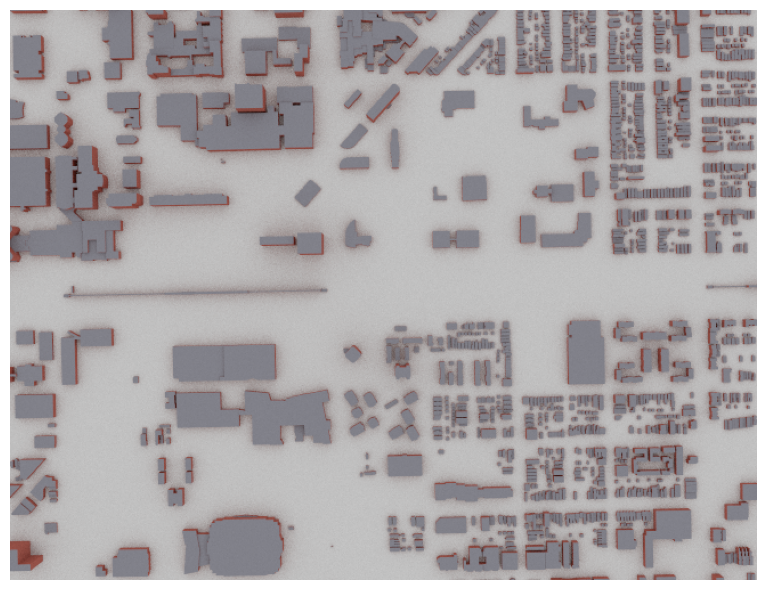

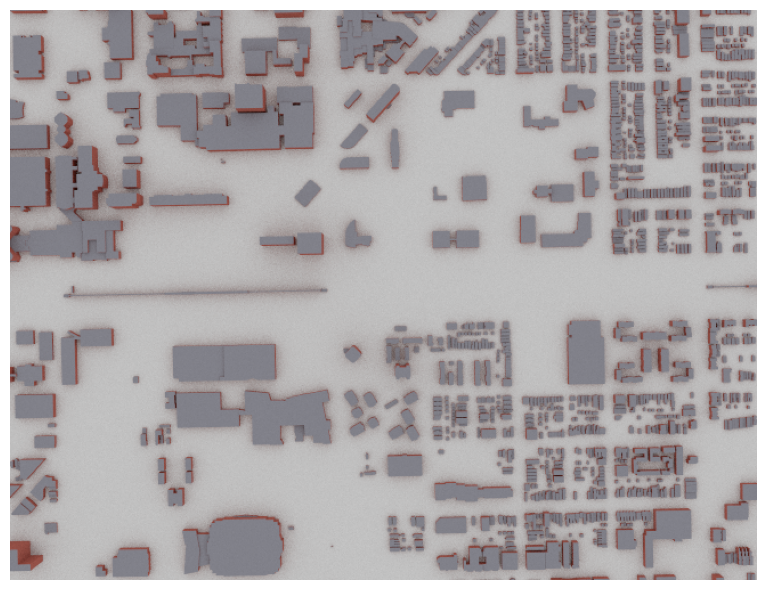

In [ ]:
overhead = Camera(position=(0.0, 2000.0, 0.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

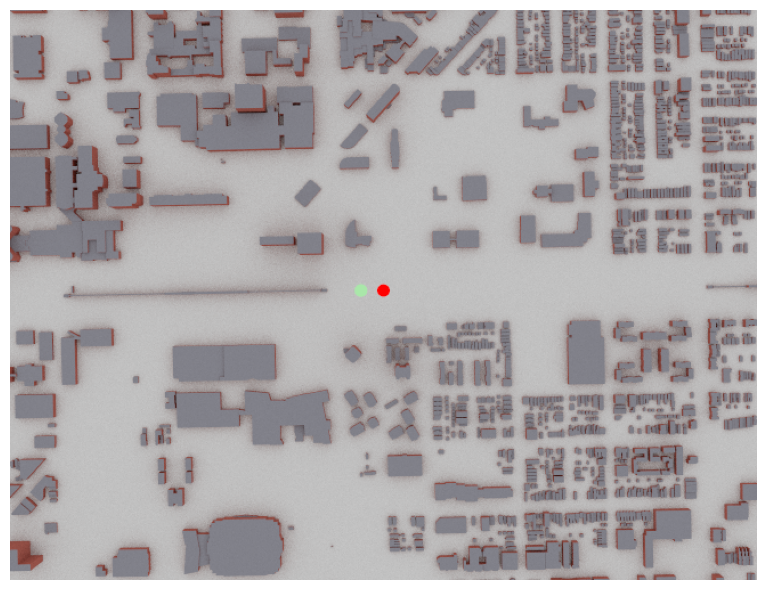

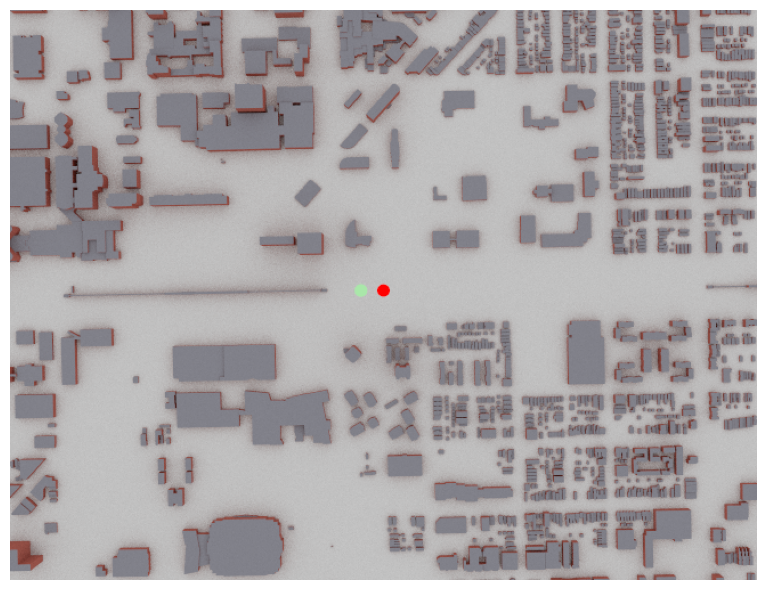

In [ ]:

tx = Transmitter(name="Tx1", position=[0,0,10], color=[1.0, 0.0, 0.0])
rx = Receiver(name="Rx1", position=[50,0,10], color=[0.4, 0.8, 0.4])
scene.add(tx)
scene.add(rx)

cam = Camera(position=(0.0, 2000.0, 0.0))
cam.look_at((0.0, 0.0, 0.0)) 

scene.render(camera=cam)